In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [251]:
data = pd.concat([pd.read_csv(f'data/rosters.nosync/rosters_{year}.csv') for year in np.arange(2015, 2026)]).reset_index(drop = True)

In [252]:
features = []
for f in ['PTS', 'FGA', 'MP', 'USG%']:
    for w in [1, 5, 10, 15, 20] :
        data[f'{f}_{w}'] = data.groupby('player_id')[f'{f}'].rolling(w, min_periods = 1).mean().reset_index(level = 0, drop = True)
        data[f'{f}_{w}'] = data.groupby('player_id')[f'{f}_{w}'].shift()
        features.append(f'{f}_{w}')

In [253]:
data['PTS_avg'] = data.groupby('player_id')['PTS'].rolling(100, min_periods = 1).mean().reset_index(level = 0, drop = True)
data['PTS_avg'] = data.groupby('player_id')['PTS_avg'].shift()

In [254]:
data_full = pd.DataFrame(np.tile(data, (10, 1)))
data_full.columns = data.columns
data_full.dropna(inplace = True)

In [255]:
data_full['thres'] = np.random.poisson(data_full['PTS_avg']) + .5
data_full.drop_duplicates(inplace = True)
data_full['target'] = (data_full['PTS'] > data_full['thres']).astype(int)

In [256]:
data_full['Year'] = data_full['game_id'].str[:4].astype(int)

In [257]:
train = data_full.copy()[
    (data_full['Year'] > 2014)
    & (data_full['Year'] < 2024)
]

test = data_full.copy()[
    data_full['Year'] >= 2024
]

In [258]:
import tensorflow as tf
from tensorflow.keras import layers, Model

n = len(features)
k = 5

# Define input layers
inputs = layers.Input(shape=(n+1,), name="features")  # Input for n features

# Classification layers
x = layers.Dense(16, activation="relu")(inputs)
x = layers.Dense(n+1, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)  # Sigmoid for binary classification

# Define the model
model = Model(inputs = inputs, outputs = output)

# Compile the model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 21)             │           357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731 (2.86 KB)

 Trainable params: 731 (2.86 KB)

 Non-trainable params: 0 (0.00 B)

In [259]:
X_train = train[features + ['thres']].to_numpy().astype(np.float32)
X_test = test[features + ['thres']].to_numpy().astype(np.float32)
y_train = train['target'].to_numpy()
y_test = test['target'].to_numpy()

In [260]:
history = model.fit(
    X_train, y_train,           
    epochs = 6,                      
    batch_size=128,                                                  
    verbose=1                            
)

Epoch 1/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 349us/step - accuracy: 0.6739 - loss: 0.6524
Epoch 2/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 380us/step - accuracy: 0.6928 - loss: 0.5800
Epoch 3/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 337us/step - accuracy: 0.6933 - loss: 0.5787
Epoch 4/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 0.6940 - loss: 0.5780
Epoch 5/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 0.6948 - loss: 0.5775
Epoch 6/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 345us/step - accuracy: 0.6953 - loss: 0.5769


In [261]:
y_pred = model.predict(X_test)

5785/5785 ━━━━━━━━━━━━━━━━━━━━ 1s 187us/step


In [262]:
test['pred'] = y_pred

In [267]:
test.sort_values(['game_id', 'player_id', 'thres'])[['Player', 'Year', 'PTS', 'PTS_avg', 'thres', 'target', 'pred']].sort_values('pred').head(20)

,Player,Year,PTS,PTS_avg,thres,target,pred
1845828,Bojan Bogdanović,2024,9,19.91,38.5,0,0.002745
1314072,Jaden Hardy,2024,4,8.38,23.5,0,0.003982
1837063,KJ Martin,2024,0,10.24,20.5,0,0.005010
2378902,Mason Plumlee,2024,5,9.27,21.5,0,0.006178
2382774,Bojan Bogdanović,2024,13,18.26,31.5,0,0.007218
259191,Cole Anthony,2024,2,10.63,22.5,0,0.007364
2648243,Bojan Bogdanović,2024,14,18.49,29.5,0,0.007491
1047179,Mason Plumlee,2024,0,9.63,20.5,0,0.007920
2368389,Brandon Ingram,2024,13,23.38,42.5,0,0.008034
782032,KJ Martin,2024,11,8.61,19.5,0,0.008323


In [264]:
thres = np.arange(0.5, 40.5)
X = np.tile(data_full[features].mean(axis = 0).to_numpy().reshape(1, -1), (len(thres), 1))
X = np.hstack((X, thres.reshape(-1, 1))).astype(np.float32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


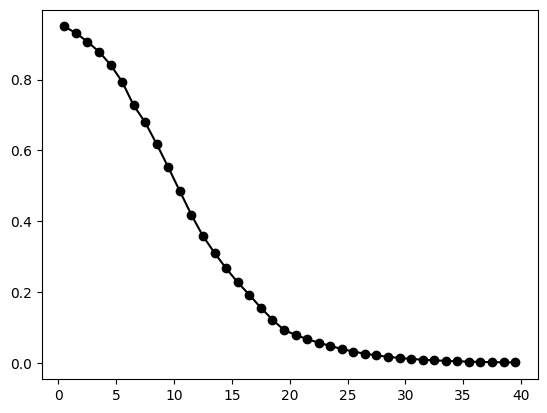

In [266]:
plt.plot(thres, model.predict(X), 'k-o')